In [37]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import ta
import numpy as np

# Download stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Calculate similarity between two time series
def calculate_similarity(current_data, past_data):
    min_length = min(len(current_data), len(past_data))
    current_data = current_data[:min_length]
    past_data = past_data[:min_length]
    
    # Normalize the data
    current_data = (current_data - np.mean(current_data)) / np.std(current_data)
    past_data = (past_data - np.mean(past_data)) / np.std(past_data)
    
    return mean_squared_error(current_data, past_data)


# Calibrate indicators
def calibrate_indicators(data, rsi_window, sma_short_window, sma_long_window):
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], rsi_window).rsi()
    data['SMA_short'] = ta.trend.sma_indicator(data['Close'], sma_short_window)
    data['SMA_long'] = ta.trend.sma_indicator(data['Close'], sma_long_window)

def find_similar_periods(ticker, current_start_date, current_end_date, past_start_year, past_end_year, step_months, top_n=5):
    current_data = get_stock_data(ticker, current_start_date, current_end_date)
    
    similar_periods = {}
    
    for year in range(past_start_year, past_end_year + 1):
        for month in range(3, 13, step_months):
            start_date = pd.Timestamp(year=year, month=month, day=1)
            end_date = start_date + pd.DateOffset(years=1) - pd.DateOffset(days=1)
            
            if end_date > current_end_date:
                continue
            
            past_data = get_stock_data(ticker, start_date, end_date)
            similarity_score = calculate_similarity(current_data['Close'], past_data['Close'])
            
            similar_periods[(start_date, end_date)] = similarity_score
    
    ranked_periods = sorted(similar_periods.items(), key=lambda x: x[1])
    
    return ranked_periods[:top_n]


def evaluate_performance(actual_data, predicted_data):
    # Remove NaN values from both actual and predicted data
    actual_data = actual_data.dropna()
    predicted_data = predicted_data.dropna()

    # Align the lengths of actual and predicted data after removing NaNs
    min_length = min(len(actual_data), len(predicted_data))
    actual_data = actual_data[:min_length]
    predicted_data = predicted_data[:min_length]

    return mean_squared_error(actual_data, predicted_data)

# Example: Assuming a simple prediction using SMA as a placeholder
def predict_prices(data, sma_short_window, sma_long_window):
    data['SMA_short'] = ta.trend.sma_indicator(data['Close'], sma_short_window)
    data['SMA_long'] = ta.trend.sma_indicator(data['Close'], sma_long_window)
    predicted_prices = data['SMA_short'] * 0.5 + data['SMA_long'] * 0.5  # Adjust this based on your prediction logic
    return predicted_prices


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


The 1st most similar year period is: (Timestamp('2023-03-01 00:00:00'), Timestamp('2024-02-29 00:00:00'))
The 2nd most similar year period is: (Timestamp('2021-03-01 00:00:00'), Timestamp('2022-02-28 00:00:00'))
The 3rd most similar year period is: (Timestamp('2022-03-01 00:00:00'), Timestamp('2023-02-28 00:00:00'))
The 4th most similar year period is: (Timestamp('2011-03-01 00:00:00'), Timestamp('2012-02-29 00:00:00'))
The 5th most similar year period is: (Timestamp('2019-03-01 00:00:00'), Timestamp('2020-02-29 00:00:00'))


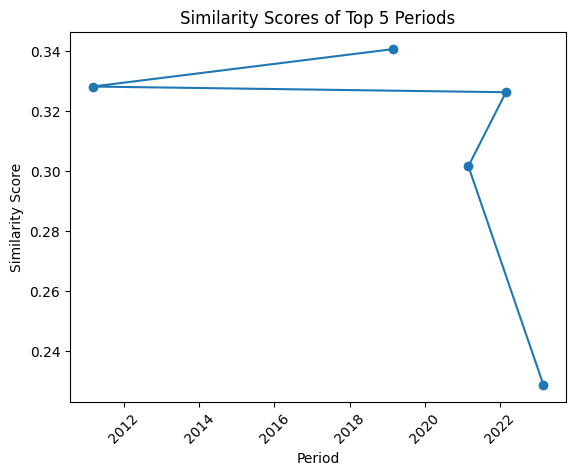

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


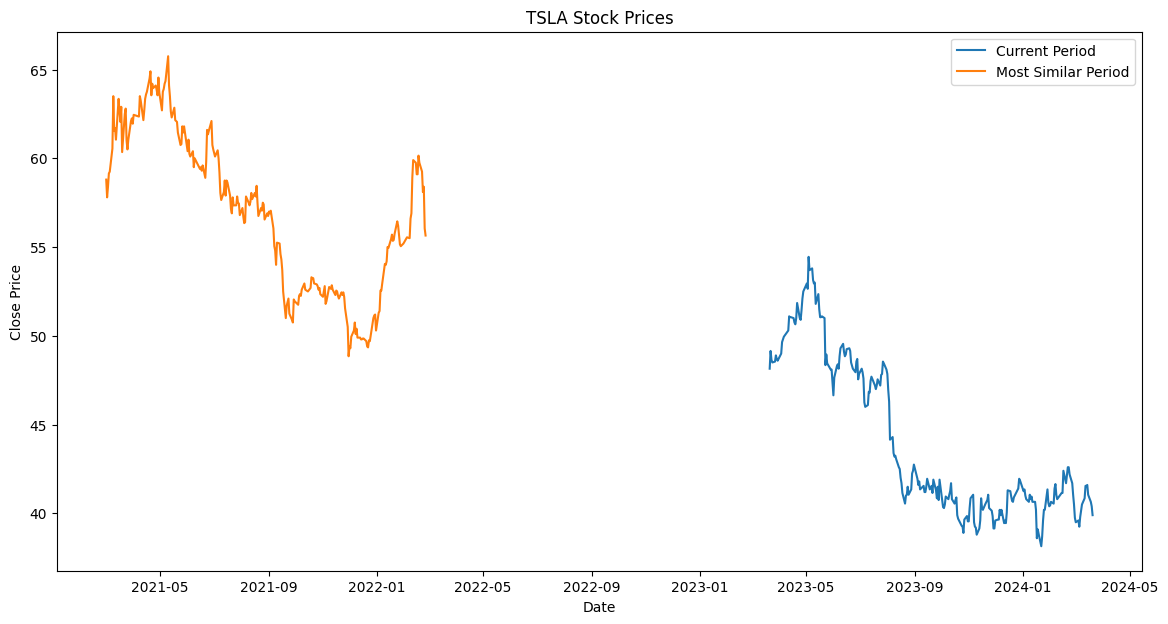

In [51]:

# Example usage
ticker_symbol = '0001.HK'
current_start = pd.Timestamp(year=2023, month=3, day=21)
current_end = pd.Timestamp(year=2024, month=3, day=21)
past_start_year = 2010
past_end_year = 2024
step_months = 12

similar_periods = find_similar_periods(ticker_symbol, current_start, current_end, past_start_year, past_end_year, step_months)
for i, period in enumerate(similar_periods, 1):
    print(f"The {i}{'' if i == 0 else 'st' if i == 1 else 'nd' if i == 2 else 'rd' if i == 3 else 'th'} most similar year period is:", period[0])


import matplotlib.pyplot as plt

# Extract the dates and similarity scores from the similar_periods list
dates = [period[0][0] for period in similar_periods[:5]]
scores = [period[1] for period in similar_periods[:5]]

# Plot the similarity scores
plt.plot(dates, scores, marker='o')
plt.xlabel('Period')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores of Top 5 Periods')
plt.xticks(rotation=45)
plt.show()


# Fetch the data for the two periods
data_current = get_stock_data('0001.HK', '2023-03-21', '2024-03-21')
data_similar = get_stock_data('0001.HK', '2021-03-01', '2022-02-28')

# Plot the closing prices for the current period
plt.figure(figsize=(14, 7))
plt.plot(data_current.index, data_current['Close'], label='Current Period')

# Plot the closing prices for the most similar period
plt.plot(data_similar.index, data_similar['Close'], label='Most Similar Period')

plt.title('TSLA Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [18]:
# Select the top similar period for calibration
top_period = similar_periods[0][0]
top_data = get_stock_data(ticker_symbol, top_period[0], top_period[1])

# Calibrate indicators
rsi_window = 14
sma_short_window = 20
sma_long_window = 50
calibrate_indicators(top_data, rsi_window, sma_short_window, sma_long_window)

# Evaluate performance with past future periods
future_start = top_period[1] + pd.DateOffset(days=1)
future_end = future_start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
future_data = get_stock_data(ticker_symbol, future_start, future_end)

predicted_prices = predict_prices(future_data, sma_short_window, sma_long_window)
actual_prices = future_data['Close']

# Evaluate performance for SMA and RSI
sma_performance = evaluate_performance(actual_prices, predicted_prices)
future_data['RSI'] = ta.momentum.RSIIndicator(future_data['Close'], rsi_window).rsi()
rsi_performance = evaluate_performance(actual_prices, future_data['RSI'])

print(f"Performance with calibrated SMA: {sma_performance}")
print(f"Performance with calibrated RSI: {rsi_performance}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Performance with calibrated SMA: 3.4532119692853067
Performance with calibrated RSI: 1644.4165090534025
